<a href="https://colab.research.google.com/github/lauvsong/instagram_fake_account_detection/blob/main/simple_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Instagram fake account detection

In [ ]:
!pip install graphviz
!pip install pydot

In [ ]:
import io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import rcParams
%matplotlib inline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, Normalizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from imblearn.over_sampling import SMOTE
from numpy.random import seed
import tensorflow as tf

In [ ]:
from google.colab import files
myfile = files.upload()

Saving train.csv to train.csv
Saving test.csv to test.csv


### Pre-processing

In [ ]:
# train, test 데이터셋 통합

dftrain = pd.read_csv(io.BytesIO(myfile['train.csv']))
dftest = pd.read_csv(io.BytesIO(myfile['test.csv']))

df = pd.concat([dftrain, dftest], axis=0, sort=True)
df.head()

,#followers,#follows,#posts,description length,external URL,fake,fullname words,name==username,nums/length fullname,nums/length username,private,profile pic
0,1000,955,32,53,0,0,0,0,0.0,0.27,0,1
1,2740,533,286,44,0,0,2,0,0.0,0.00,0,1
2,159,98,13,0,0,0,2,0,0.0,0.10,1,1
3,414,651,679,82,0,0,1,0,0.0,0.00,0,1
4,151,126,6,0,0,0,2,0,0.0,0.00,1,1


In [ ]:
print(df.shape)

(696, 12)


In [ ]:
# 정규화 진행
# RobustScaler 활용

continuous_features = ['nums/length username', 'description length', '#posts', '#followers', '#follows']

scaler = RobustScaler()
for feature in continuous_features:
  df[feature] = df[feature].astype('float64')
  df[feature] = scaler.fit_transform(df[feature].values.reshape(-1, 1))

df.head()

,#followers,#follows,#posts,description length,external URL,fake,fullname words,name==username,nums/length fullname,nums/length username,private,profile pic
0,1.281874,1.300046,0.298701,1.514286,0,0,0,0,0.0,0.818182,0,1
1,3.954685,0.519649,3.597403,1.257143,0,0,2,0,0.0,0.000000,0,1
2,-0.009985,-0.284790,0.051948,0.000000,0,0,2,0,0.0,0.303030,1,1
3,0.381720,0.737864,8.701299,2.342857,0,0,1,0,0.0,0.000000,0,1
4,-0.022273,-0.233010,-0.038961,0.000000,0,0,2,0,0.0,0.000000,1,1


In [ ]:
# SMOTE Oversampling
# 테스트 데이터셋 split

x = df[pd.notnull(df['fake'])].drop(['fake'], axis=1)
y = df[pd.notnull(df['fake'])]['fake']

sm = SMOTE(ratio='auto', kind='regular')
x,y = sm.fit_sample(x, list(y))

x_train, x_test, y_train, y_test = train_test_split(x, y, stratify=y, test_size=0.2, random_state=42)

In [ ]:
print(x_train.shape, x_test.shape)
print(list(y_train).count(1), list(y_train).count(0))
print(list(y_test).count(1), list(y_test).count(0))

(556, 11) (140, 11)
278 278
70 70


### Neural Network model

In [ ]:
# Logistic Regression
# optimizer : nadam
# activation : 은닉층은 relu, 출력층은 sigmoid
# 은닉층 둘 추가

model = Sequential()
model.add(Dense(11, input_dim=x_train.shape[1], activation='relu', name='input_layer'))
model.add(Dense(22, activation='relu', name='hidden_layer'))
model.add(Dense(22, activation='relu', name='hidden_layer2'))
model.add(Dense(22, activation='relu', name='hidden_layer3'))

model.add(Dropout(0.1))
model.add(Dense(1, activation='sigmoid', name='output_layer'))
model.compile(loss='binary_crossentropy', optimizer='nadam', metrics='accuracy')

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (Dense)          (None, 11)                132       
_________________________________________________________________
hidden_layer (Dense)         (None, 22)                264       
_________________________________________________________________
hidden_layer2 (Dense)        (None, 22)                506       
_________________________________________________________________
hidden_layer3 (Dense)        (None, 22)                506       
_________________________________________________________________
dropout_4 (Dropout)          (None, 22)                0         
_________________________________________________________________
output_layer (Dense)         (None, 1)                 23        
Total params: 1,431
Trainable params: 1,431
Non-trainable params: 0
____________________________________________________

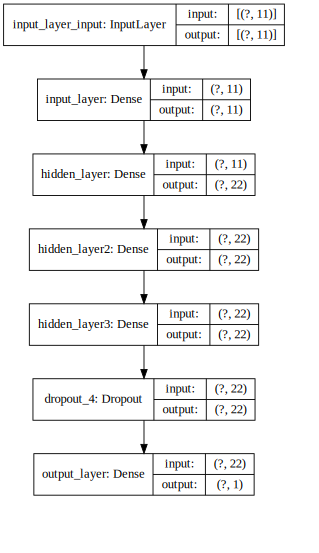

In [ ]:
# model 시각화

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model, show_shapes=True, dpi=65).create(prog='dot', format='svg'))

### training

In [ ]:
# epoch 일정 범위 내 오차 커질 시 (과적합 발생 시작 시) 조기종료 모듈 추가
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1)
train = model.fit(x_train, y_train, epochs=100, validation_split=0.2, verbose=0, callbacks=[early_stopping])
val_acc = np.mean(train.history['accuracy'])
print("\n%s: %.2f%%" % ('accuracy', val_acc*100))

Epoch 00040: early stopping

accuracy: 89.79%


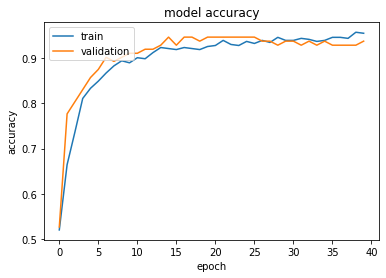

In [ ]:
plt.plot(train.history['accuracy'])
plt.plot(train.history['val_accuracy'])
plt.title('model accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

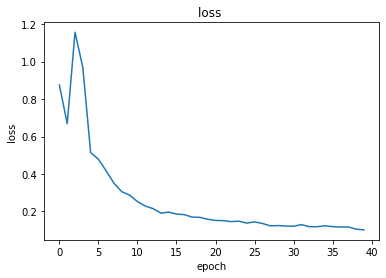

In [ ]:
plt.plot(train.history['loss'])
plt.title('loss ')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

### Evaluation

In [ ]:
# test dataset 정확도

results = model.evaluate(x_test, y_test)
print("Test Result (loss, acc):", results)

5/5 [==============================] - 0s 2ms/step - loss: 0.2703 - accuracy: 0.9429
Test Result (loss, acc): [0.2702712416648865, 0.9428571462631226]
